In [13]:
%load_ext autoreload
%autoreload 1
%aimport Utils
%aimport MatrixLinkGenerator
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
np.set_printoptions(linewidth=np.inf)
from obspy import UTCDateTime
import datetime
import json
import pickle
import matplotlib.pyplot as plt
import math
from geographiclib.geodesic import Geodesic
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist, squareform
from Utils import trainingResults
# plt.rcParams['figure.figsize'] = [50, 200]
plt.rcParams['figure.figsize'] = [16, 12]
params = json.loads('''{
    "extents": {
        "s1": {
            "latMin": 22.0,
            "latMax": 40.0,
            "lonMin": 33.0,
            "lonMax": 62.0
        }
    },
    "location": "s1",
    "maxDepth": 50.0,
    "maxStationElevation": 0.5,
    "trainingGeneratorSourceFile": "./Training/Inputs/S1 00.gz",
    "trainingEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3+ Arrivals 120 TimeNorm.npz",
    "validationGeneratorSourceFile": "./Inputs/S1 00.gz",
    "validationEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3+ Arrivals 120 TimeNorm.npz",
    "arrivalProbsFile": "./Training/RSTT Model/S1 Dropouts.npy",
    "arrivalProbMods": {
        "Pg": 7.0,
        "Pn": 4.5,
        "Sg": 7.0,
        "Sn": 25.0
    },
    "eventsPerExample": {
        "min": 1,
        "max": 4
    },
    "stationsPerBatch": {
        "min": 45,
        "max": 55
    },
    "timeShifts": {
        "min": -0.50,
        "max": 0.50
    },
    "batchSize": 1000,
    "samplesPerEpoch": 1000000,
    "validationSamplesPerEpoch": 250000,
    "epochs": 400,
    "model": "./Training/Models/Example Error/E048 L1.3383 A0.6707 P0.6239 R0.1791 HL656.5 VL0.3995 VA0.6934 VP0.6723 VR0.3387 VHL324.6.h5",
    "evalInFile": "./Inputs/S1 00.gz",
    "evalOutFile": "./Training/Evaluation.gz",
    "prlEvalOutFile": "./Training/PRL Evaluation.gz",
    "maxArrivals": 50,
    "minArrivals": 3,
    "maxNoise": 0.20,
    "clusterStrength": 0.9,
    "timeNormalize": 120,
    "associationWindow": 300,
    "evalWindow": 10.0,
    "phases": {
        "Pg": 0, "PcP": 0, "Pb": 0,
        "P": 1, "Pn": 1,
        "S": 2, "Sg": 2, "ScP": 2, "Lg": 2, "Sb": 2,
        "Sn": 3
    },
    "modelArch": {
        "dense": [32, 32, 64, 128, 128],
        "transformers": [256, 256],
        "heads": 4,
        "dense2": [128, 128, 128],
        "grus": [256, 256]
    }
}''')
tf.config.list_physical_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
import numpy as np
import pandas as pd
from obspy import UTCDateTime as dt
import random
import rstt
from copy import deepcopy
from collections import deque
import math
modelPath = "./Training/RSTT Model/pdu202009Du.geotess"
phases = ['Pg','Pn','Lg','Sn']

def generateEventFile(params, trainingSet = False):
    if trainingSet:
        eventsFile = params['trainingEventsFile']
        generatorFile = params['trainingGeneratorSourceFile']
    else:
        eventsFile = params['validationEventsFile']
        generatorFile = params['validationGeneratorSourceFile']
    try:
        events = np.load(eventsFile, allow_pickle=True)['events'].flatten()[0]
        print("Training events loaded.") if trainingSet else print("Validation events loaded.")
    except:
        print("Events not loaded. Building from scratch.")
        extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
        latRange = abs(extents[1] - extents[0])
        lonRange = abs(extents[3] - extents[2])
        timeNormalize = params['timeNormalize']
        phases = params['phases']
        events = {}
        inputArrivals = pd.read_pickle(generatorFile)
        groupedEvents = (inputArrivals.groupby('EVID').filter(lambda x: len(x) >= params['minArrivals'])).groupby('EVID')
        count = 0
        for eid, arrivals in groupedEvents:
            count += 1
            print("\rBuilding event list: " + str(count) + ' / ' + str(len(groupedEvents)), end='')
            eventArrivals = []
            first = dt(arrivals.TIME.min())
            evtime = -(first - dt(arrivals.EV_TIME.min())) / timeNormalize
            for i, arrival in arrivals.iterrows():
                thisArrival = [abs((arrival.ST_LAT - extents[0]) / latRange), # normalized station lat
                               abs((arrival.ST_LON - extents[2]) / lonRange), # normalized station lon
                               ((dt(arrival.TIME) - first) / timeNormalize),  # normalized arrival time
                               phases[arrival.PHASE],                         # phase
                               1.,                                            # valid arrival flag
                               5.0 / timeNormalize,                           # arrival uncertainty
                               0.9,                                           # retention rate when dropping some arrivals
                               abs((arrival.EV_LAT - extents[0]) / latRange), # normalized event lat
                               abs((arrival.EV_LON - extents[2]) / lonRange), # normalized event lon
                               arrival.EV_DEPTH / extents[4],                 # normalized event depth
                               evtime]                                        # normalized event time (relative to first arrival)
                eventArrivals.append(thisArrival)
            events[eid] = np.array(eventArrivals)
        np.savez_compressed(eventsFile, events=events)
        print()
    eventList = list(events.keys())
    return events, eventList

def buildAssociationMatrix(evids):
    L = np.zeros((len(evids), len(evids))) + 99
    sparse_evids = evids[evids>=0]
    l = np.ones((len(sparse_evids), len(sparse_evids))) * sparse_evids.reshape((-1, 1))
    L[:len(sparse_evids), :len(sparse_evids)] = (l == l.T) * 1
    return L

def synthesizeEventsFromEventFile(params, events, eventList, trainingSet = False):
    maxArrivals = params['maxArrivals']
    minTimeShift = params['timeShifts']['min']
    maxTimeShift = params['timeShifts']['max']
    minEvents = params['eventsPerExample']['min']
    maxEvents = params['eventsPerExample']['max']+1 # because using in np.random.randint
    dropFactor = 0.0
    batchSize = params['batchSize']

    while True:
        X = []
        Y = []
        example = 0
        while example < batchSize:
            #Setup - choose random events, with the first being the primary event
            numEvents = np.random.randint(minEvents, maxEvents)
            chosenEvents = random.sample(eventList, numEvents)
            timeShifts = np.random.uniform(minTimeShift, maxTimeShift, size=numEvents-1)
            for i in range(0, len(chosenEvents)):
                thisEvent = events[chosenEvents[i]]
                #Randomly drop some picks from the event
                if trainingSet:
                    drops = thisEvent[:,6]
                    drops = drops + dropFactor*(1-drops) if dropFactor > 0 else drops*(1+dropFactor)
                    drops = np.random.binomial(1,drops)
                    idx = np.where(drops==1)[0]
                    thisEvent = thisEvent[idx,:]
                if i == 0:
                    sequence = thisEvent
                    sequence[:,4] = i
                else:
                    #Add the picks from this event
                    currentLength = len(sequence)
                    sequence = np.append(sequence, thisEvent, axis=0)
                    #Shift the starting time of this event
                    sequence[currentLength:currentLength+len(thisEvent),[2,10]] += timeShifts[i-1]
                    sequence[currentLength:currentLength+len(thisEvent),4] = i

            #Add random arrival time errors, except for the first pick of the primary event
            if trainingSet:
                timeShifts = np.random.uniform(-sequence[1:,5], sequence[1:,5])
                sequence[1:,2] += timeShifts

            #Sort by arrival time, drop picks with negative arrival times
            idx = np.argsort(sequence[:,2])
            remove = len(np.where((sequence[:,2] < 0))[0])
            idx = idx[remove:]
            sequence = sequence[idx,:]
            if len(sequence) == 0: #We lost all the valid arrivals, so scrap this training example
                continue

            #Make labels array
            labels = buildAssociationMatrix(sequence[:,4])

            #Reset primary event times
            ones = np.where(labels[0]==1)
#             if len(ones[0]) == 0: #We lost all the valid arrivals, so scrap this training example
#                 continue
            sequence[ones,2] -= sequence[ones,2][0][0]
            idx = np.argsort(sequence[:,2])

            #Truncate picks over maximum allowed
            idx = idx[:maxArrivals]
            sequence = sequence[idx,:]
            labels = labels[idx,:maxArrivals]

            sequence[:,4] = 1.
            #Pad the end if not enough picks were selected
            padding = maxArrivals - len(sequence)
            if padding > 0:
                labels = np.pad(labels, (0,maxArrivals-len(labels)))
                sequence_ = np.zeros((maxArrivals, 11))
                sequence_[sequence.shape[0]:,2] = 0.0
                sequence_[:sequence.shape[0], :] = sequence
                sequence = sequence_
            X.append(sequence)
            Y.append(labels)
            example += 1
            
        #Yield these training examples
        X = np.array(X)
#         Y = {"association": np.array(Y), "location": X[:,:,[7,8]], "depth": X[:,:,9], "time": X[:,:,10]}
        Y = {"association": np.array(Y), "location": X[:,:,[7,8]]}
        X = {"phase": X[:,:,3], "numerical_features": X[:,:,[0,1,2,4]]}
        yield X, Y

def synthesizeEvents(params):
    def get_TT(srcLatDeg, srcLonDeg, srcDepKm, rcvLatDeg, rcvLonDeg, rcvDepKm, phase, slbm):
        phase = phases[phase]
        # create a great circle from source to the receiver
        slbm.createGreatCircle(phase,
            rstt.deg2rad(srcLatDeg),
            rstt.deg2rad(srcLonDeg),
            srcDepKm,
            rstt.deg2rad(rcvLatDeg),
            rstt.deg2rad(rcvLonDeg),
            rcvDepKm)
        # get the distance and travel time from source --> receiver
        travelTimeSec = slbm.getTravelTime()   # compute travel time (sec)
        # get the travel time uncertainty
        travelTimeUncertSec   = slbm.getTravelTimeUncertainty()
        return travelTimeSec, travelTimeUncertSec
        
    def haversine(lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between every combination of two points
        on the earth (specified in decimal degrees)
        """
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        lat1 = lat1[:, np.newaxis]
        lon1 = lon1[:, np.newaxis]
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
    
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        km = 2 * np.arcsin(np.sqrt(a)) * 6378.1
        bucket = (km/100).astype(int)
        bucket = np.clip(bucket, 0, 11)
        return bucket

    # instantiate an RSTT object
    slbm = rstt.SlbmInterface()
    # load the velocity model
    slbm.loadVelocityModel(modelPath)
    # load the arrival probabilities
    arrivalProbs = np.load(params['arrivalProbsFile']) # Phase (Pg, Pn, Lg, Sn), Distance (0-11), Magnitude (0-5)
    
    # read in all the parameters first to avoid redundant lookups. Really just more readable
    timeNormalize = params['timeNormalize']
    batchSize = params['batchSize']
    maxArrivals = params['maxArrivals']
    minTimeShift = params['timeShifts']['min']
    maxTimeShift = params['timeShifts']['max']
    totalEvents = int(batchSize/3)
    minEvents = params['eventsPerExample']['min']
    maxEvents = params['eventsPerExample']['max']+1 # because using in np.random.randint
    minStations = params['stationsPerBatch']['min']
    maxStations = params['stationsPerBatch']['max']+1 # because using in np.random.randint
    maxNoise = maxArrivals*params['maxNoise']
    extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
    latRange = abs(extents[1] - extents[0])
    lonRange = abs(extents[3] - extents[2])
    arrivalProbs = np.load(params['arrivalProbsFile'])/100 # Phase (Pg, Pn, Lg, Sn), Distance (0-11), Magnitude (0-5)
    arrivalProbs[0] = np.clip(arrivalProbs[0]*params['arrivalProbMods']['Pg'],0,1)
    arrivalProbs[1] = np.clip(arrivalProbs[1]*params['arrivalProbMods']['Pn'],0,1)
    arrivalProbs[2] = np.clip(arrivalProbs[2]*params['arrivalProbMods']['Sg'],0,1)
    arrivalProbs[3] = np.clip(arrivalProbs[3]*params['arrivalProbMods']['Sn'],0,1)
    
    def processEvents(events):
        numEvents = np.random.randint(minEvents, maxEvents, batchSize)
        examplesList = [random.sample(range(len(events)), evs) for evs in numEvents]
        examples = [[deepcopy(events[e]) for e in examplesList[ex]] for ex in range(len(examplesList))]

        # generate noise
        numNoise = np.random.randint(0, maxNoise, batchSize)
        totalNoise = np.sum(numNoise)
        noise = np.zeros((totalNoise, 9))
        noise[:,[0,1,5,6]] = stations[np.random.randint(0, numStations, totalNoise)][:,[0,1,0,1]] # location of noise arrivals = station location
        noise[:,2] = np.random.uniform(0, 1, totalNoise)
        noise[:,3] = np.random.choice([0.,1.,2.,3.], size=totalNoise, p=[.125,.74,.115,.02])
        noiseUsed = 0

        # generate all the amounts to shift events and phases around
        timeMods = np.random.uniform(minTimeShift,maxTimeShift,np.sum(numEvents-1))
        timeModsUsed = 0

        X = np.zeros((batchSize, maxArrivals, 5))
        Ya = np.zeros((batchSize, maxArrivals, maxArrivals)) # Association matrix labels
        Yl = np.zeros((batchSize, maxArrivals, 4)) # Location/depth/time labels
        for i in range(batchSize):
            example = examples[i]
            ev = 0
            evids = deque([ev]*len(example[ev]))
            for event in example[1:]:
                ev += 1
                evids.extend([ev]*len(example[ev]))
                event[:,[2,8]] += timeMods[timeModsUsed]
                timeModsUsed += 1
    
            # Add noise
            example.append(noise[noiseUsed:noiseUsed+numNoise[i]])
            noiseUsed += numNoise[i]
            examples[i] = np.concatenate(example)
            ev += 1
            evids.extend(np.array(range(ev,ev+numNoise[i])))

            examples[i][1:,2] += examples[i][1:,4]*np.random.normal(0,0.25,len(examples[i][1:]))
            examples[i][:,4] = evids
            idx = np.argsort(examples[i][:,2])
            start = np.argmax(idx == 0)
            idx = idx[start:start+maxArrivals]
            examples[i] = examples[i][idx]
            Ya[i][:len(examples[i]),:len(examples[i])] = buildAssociationMatrix(examples[i][:,4])
            Yl[i][:len(examples[i]),:] = examples[i][:,[5,6,7,8]]
            examples[i][:,4] = 1.
            X[i][:len(examples[i])] = examples[i][:,:5]

        X = {"phase": X[:,:,3], "numerical_features": X[:,:,[0,1,2,4]]}
#         Y = {"association": Ya, "location": Yl[:,:,[0,1]], "depth": Yl[:,:,2], "time": Yl[:,:,3]}
        Y = {"association": Ya, "location": Yl[:,:,[0,1]]}
        return X, Y

    while(True):
        # Create a random numbers of events per training example...
        # ...and a random numbers of receiving stations to be used for each training example
        numStations = np.random.randint(minStations, maxStations)
        genEvents = np.zeros((totalEvents, 6))
        stations = np.zeros((numStations, 6))
        genEvents[:,0:2] = np.random.rand(totalEvents, 2) # [evLat, evLon, evDepth]
        genEvents[:,3] = abs(np.random.normal(loc=.2, scale=.25, size=totalEvents))
        stations[:,0:3] = np.random.rand(numStations, 3) # [stLat, stLon, stDepth]

        # Calculate the denormalized event and station latitudes
        genEvents[:,3] = genEvents[:,0]*latRange + extents[0]
        stations[:,3] = stations[:,0]*latRange + extents[0]
        # Calculate the denormalized event and station longitudes
        genEvents[:,4] = genEvents[:,1]*lonRange + extents[2]
        stations[:,4] = stations[:,1]*lonRange + extents[2]
        # Calculate the denormalized event and stations depths
        genEvents[:,5] = genEvents[:,2]*extents[4]
        stations[:,5] = -stations[:,2]*extents[5] # because it's elevation, I think

        # Generate random magnitudes (as buckets for looking up in the arrival probability table)
        # Calculate the distances between stations and events and get the buckets for looking up in the probability table
        mags = np.random.randint(0, 6, totalEvents)
        dists = haversine(genEvents[:,3],genEvents[:,4],stations[:,3],stations[:,4]) # distance buckets as dists[event, station]

        # Lookup retention values for each training example, phase, event, station
        arrivals = arrivalProbs[:,dists,mags[:,np.newaxis]]
        arrivals = np.random.binomial(1,arrivals) # arrivals[phase][event][station]
        arrivals = np.argwhere(arrivals==1)
        evids, counts = np.unique(arrivals[:,1], return_counts=True) # Ensure there are at least a few arrivals for each event
        evids = evids[np.where(counts >= params['minArrivals'])]
        arrivals = arrivals[np.isin(arrivals[:,1],evids)]

        # Build the events list
        events = np.full((len(arrivals),10),np.nan) # normal station lat, normal station lon, travel time, phase, travel time uncertainty, event lat, event lon, event depth, event time, event id
        currentPhase = 0
        for arrival in range(len(arrivals)):
            ph, ev, st = arrivals[arrival]
            try:
                tt, uncert = get_TT(genEvents[ev,3],genEvents[ev,4],genEvents[ev,5],stations[st,3],stations[st,4],stations[st,5],ph,slbm)
#                 tt += uncert*np.random.normal(0,0.25) # Add random arrival errors
                events[currentPhase] = [stations[st,0], stations[st,1], tt, ph, uncert, genEvents[ev,0], genEvents[ev,1], genEvents[ev,2], 0, ev]
                currentPhase += 1
            except Exception as e:
        #                 print(e)
                pass
        events = events[~np.any(np.isnan(events), axis=1)] # Remove NaNs (from failed TT calculations)
        events[:,[2,4]] /= timeNormalize # Normalize time values
        events = events[np.lexsort((events[:,2], events[:,-1]))] # Sort by event id, then by travel time

        events = np.split(events[:,:-1], np.unique(events[:,-1], return_index=True)[1][1:]) # arrivals as an array of events
        for event in events:
            event[:,[2,8]] -= event[0,2] # convert travel time to arrival time, retain event time TODO: can this be done vectorized?
        yield processEvents(events)

In [15]:
#MatrixLinkTrainer
import tensorflow as tf
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Embedding, Reshape, concatenate, Dense, Bidirectional, GRU, MultiHeadAttention, LayerNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import logging
import json
# from MatrixLinkGenerator import generateEventFile, synthesizeEvents, synthesizeEventsFromEventFile
from Utils import nzBCE, nzMSE1, nzMSE2, nzHaversine, nzDepth, nzTime, nzAccuracy, trainingResults

@tf.autograph.experimental.do_not_convert
def MatrixLink(params):
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    def buildModel(modelArch):
        outputs = []
        inputs = []
        numericalInputs = Input(shape=(None,4), name='numerical_features')
        outputs.append(numericalInputs)
        inputs.append(numericalInputs)
        categoricalInputs = Input(shape=(None,1), name='phase')
        embed = Embedding(4, 2, trainable=True, embeddings_initializer=RandomNormal())(categoricalInputs)
        embed = Reshape(target_shape=(-1,2))(embed)
        outputs.append(embed)
        inputs.append(categoricalInputs)
        outputs = concatenate(outputs)

        def TransformerBlock(inputs, embed_dim, ff_dim, num_heads=2, rate=0.1, eps=1e-6):
            attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
#             attn_output = Dropout(rate)(attn_output)
            out1 = LayerNormalization(epsilon=eps)(inputs + attn_output)
            ffn_output = Dense(ff_dim, activation="relu")(out1)
            ffn_output = Dense(embed_dim)(ffn_output)
#             ffn_output = Dropout(rate)(ffn_output)
            return LayerNormalization(epsilon=eps)(out1 + ffn_output) 

        for d1Units in modelArch['dense']:
            outputs = Dense(units=d1Units, activation=tf.nn.relu)(outputs)
        transformerOutputs = outputs
        gruOutputs = outputs

        for tUnits in modelArch['transformers']:
            transformerOutputs = TransformerBlock(transformerOutputs, d1Units, tUnits, modelArch['heads'])
        for gUnits in modelArch['grus']:
            gruOutputs = Bidirectional(GRU(gUnits, return_sequences=True))(gruOutputs)

        outputs = concatenate([transformerOutputs, gruOutputs], axis=2)
        for tUnits in modelArch['transformers']:
            outputs = TransformerBlock(outputs, d1Units+gUnits*2, tUnits, modelArch['heads'])
        
        association = Dense(units=params['maxArrivals'], activation=tf.nn.sigmoid, name='association')(outputs)
        location = Dense(units=2, name='location')(outputs)
        # depth = Dense(units=1, name='depth')(outputs)
        # time = Dense(units=1, name='time')(outputs)
        
        # model = Model(inputs=inputs, outputs=[association, location, depth, time])
        model = Model(inputs=inputs, outputs=[association, location])
        # losses = { 'association': nzBCE, 'location': nzMSE2, 'depth': nzMSE1, 'time': nzMSE1 }
        losses = { 'association': nzBCE, 'location': nzMSE2 }
        # weights = { 'association': 1.0, 'location': 6.0, 'depth': 0.075, 'time': 1.0 }
        weights = { 'association': 1.0, 'location': 10.0 }
        metrics = { 'association': [nzAccuracy, Precision(name='precision'), Recall(name='recall')],
                    'location': nzHaversine }
                    # 'depth': nzDepth,
                    # 'time': nzTime }
        model.compile(optimizer=Adam(clipnorm=0.00001), loss=losses, loss_weights=weights, metrics=metrics)
        return model

    model = buildModel(params['modelArch'])
    try:
        model.load_weights(params['model'])
        print("Loaded previous weights.")
    except Exception as e:
        print(e)
        print("No previous weights loaded.")
    print(model.summary())
    return model

class saveCb(Callback):
    def on_train_begin(self, logs=None):
        self.best = 100.
    def on_epoch_end(self, epoch, logs=None):
        if logs['loss'] < self.best:
            self.best = logs['loss']
            print('Saving best model with loss', self.best)
            # modelName = 'E%03d L%.4f A%.4f P%.4f R%.4f HL%.1f DL%.3f TL%.3f VL%.4f VA%.4f VP%.4f VR%.4f VHL%.1f VDL%.3f VTL%.3f.h5' %\
            #     (epoch, logs['loss'], logs['association_nzAccuracy'], logs['association_precision'], logs['association_recall'], logs['location_nzHaversine'], logs['depth_nzDepth'], logs['time_nzTime'],
            #      logs['val_loss'], logs['val_association_nzAccuracy'], logs['val_association_precision'], logs['val_association_recall'], logs['val_location_nzHaversine'], logs['val_depth_nzDepth'], logs['val_time_nzTime'])
            modelName = 'E%03d L%.4f A%.4f P%.4f R%.4f HL%.1f VL%.4f VA%.4f VP%.4f VR%.4f VHL%.1f.h5' %\
                (epoch, logs['loss'], logs['association_nzAccuracy'], logs['association_precision'], logs['association_recall'], logs['location_nzHaversine'], 
                 logs['val_loss'], logs['val_association_nzAccuracy'], logs['val_association_precision'], logs['val_association_recall'], logs['val_location_nzHaversine'])
            model.save("./Training/Models/Example Error/"+modelName)

Validation events loaded.
Unable to open file (unable to open file: name = './Training/Models/Example Error/E048 L1.3383 A0.6707 P0.6239 R0.1791 HL656.5 VL0.3995 VA0.6934 VP0.6723 VR0.3387 VHL324.6.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
No previous weights loaded.
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
phase (InputLayer)              [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 1, 2)   8           phase[0][0]                      
__________________________________________________________________________________________________
numerical_features (InputLayer) [(None, None, 4)]    0                        

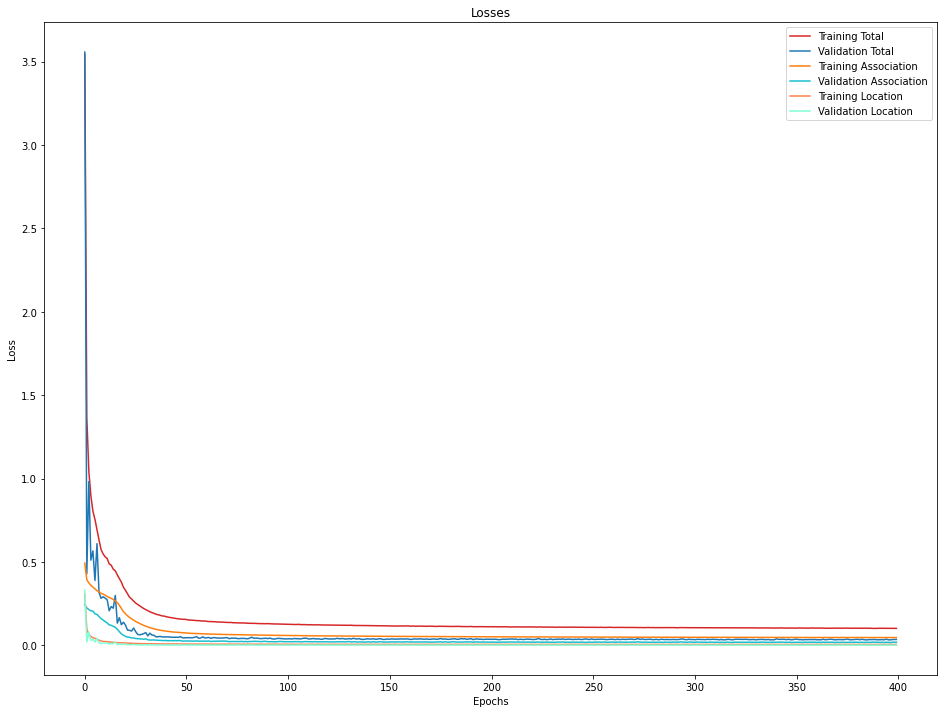

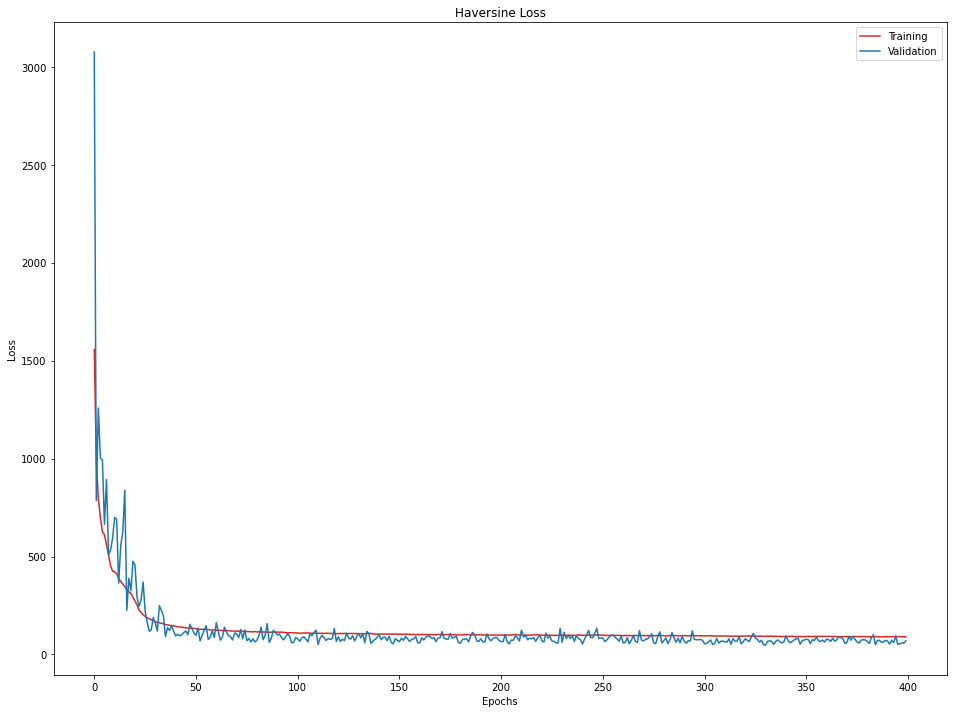

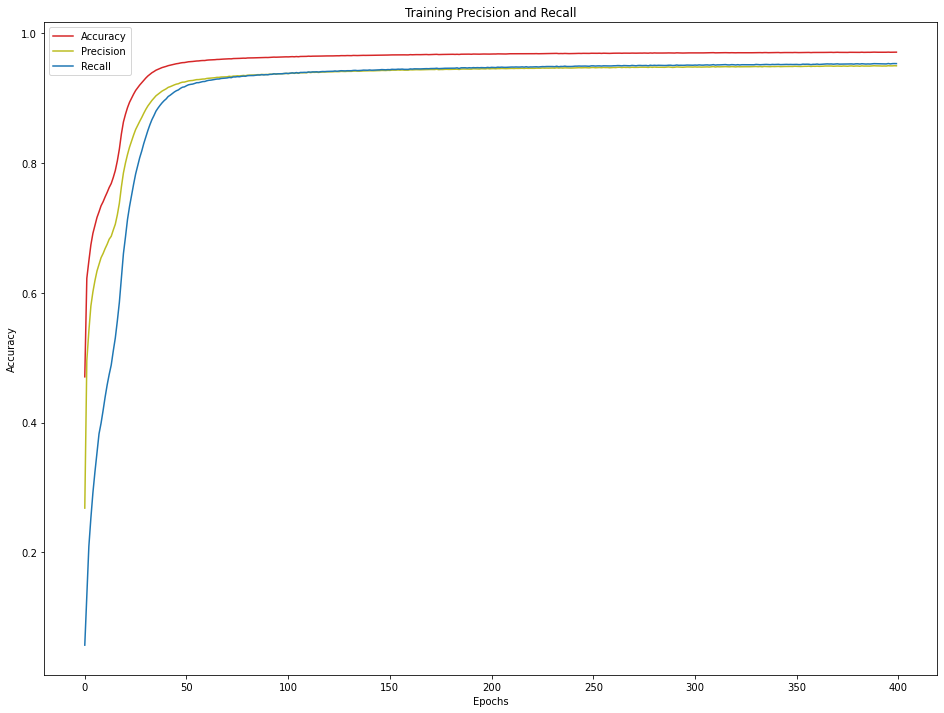

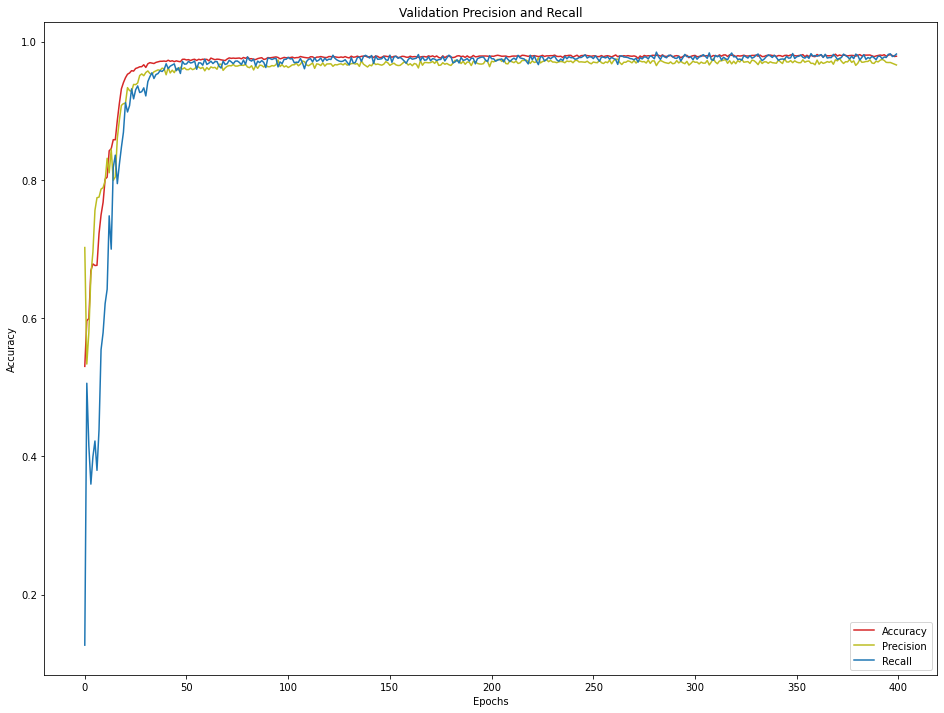

<Figure size 1152x864 with 0 Axes>

In [17]:
# tf.config.threading.set_intra_op_parallelism_threads(2)
# tf.config.threading.set_inter_op_parallelism_threads(2)

# trainingEvents, trainingEventList = generateEventFile(params, trainingSet=True)
validationEvents, validationEventList = generateEventFile(params)

# generator = synthesizeEventsFromEventFile(params, trainingEvents, trainingEventList, trainingSet=True)
generator = synthesizeEvents(params)
vgen = synthesizeEventsFromEventFile(params, validationEvents, validationEventList)
# vgen = synthesizeEvents(params)

model = MatrixLink(params)
history = model.fit(generator,
                 validation_data=vgen,
                 steps_per_epoch= params['samplesPerEpoch']/params['batchSize'],
                 validation_steps = params['validationSamplesPerEpoch']/params['batchSize'],
                 epochs=params['epochs'],
                 callbacks=[saveCb(), EarlyStopping(monitor='loss', patience=40), CSVLogger('./Training/Models/Example Error/logs.csv', append = True)],
                 verbose=1)
trainingResults(np.genfromtxt('./Training/Models/Example Error/logs.csv', delimiter=',', names=True))